# Visualization and Exploration

Valuable insights can be gleaned from inspecting how the data is distributed. Visualization also helps build a concrete understanding how all of the data fits together and the results of predictive models.

# Setup

In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
import rasterio as rio 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# File path for project data
FILE_PATH = "<LOCAL PATH>"
# File path for NC counties
NC_COUNTIES = FILE_PATH + "NC_counties/North_Carolina_State_and_County_Boundary_Polygons.shp"
# File Path for NC Parks
CLEANED_DATA = FILE_PATH + "Output/Cleaned_Data/"
# Raster Images of County Elevation
ELEV_PATH = FILE_PATH + "Elevation_Data/"
# Training Data
TRAIN_PATH = FILE_PATH + "Output/Training_Data/"

# Annotation Arrow for plots
ANNO_ARROW = dict(facecolor='r', shrink=0.025, width = 2, headwidth = 8)
# Park Color
PARK_COLOR = 'mediumseagreen'
# NC Map Fig size
NC_MAP_SIZE = (15,10)
# Size for a single plot
PLOT_1 = (10, 7)
# Sizes for others plots
PX = 7
PY = 5

## Data

In [15]:
# County Boundarys
nc = gpd.read_file(NC_COUNTIES, engine = "pyogrio")
# All managed areas / parks
parks = gpd.read_file(CLEANED_DATA + "parks_all.shp", engine = "pyogrio")
# All of the data will be projected to the NC Counties CRS
parks = parks.to_crs(nc.crs)
# Managed areas and trail systems combined
tp_merge = gpd.read_file(CLEANED_DATA + "trails_parks_merged.shp")
# Traing Data
trails_std = pd.read_csv(TRAIN_PATH + "training_std.csv")
trails_reg = pd.read_csv(TRAIN_PATH + "training_non.csv")
trails_std["mtb"] = np.where(trails_std.id.str.contains("trail_row", regex = False), "MTB", "No MTB")
trails_reg["mtb"] = np.where(trails_reg.id.str.contains("trail_row", regex = False), "MTB", "No MTB")
# Prediction results
pred = pd.read_csv(TRAIN_PATH + "prediction_results.csv", index_col = 0)

# Distribution of Managed Areas Throughout NC

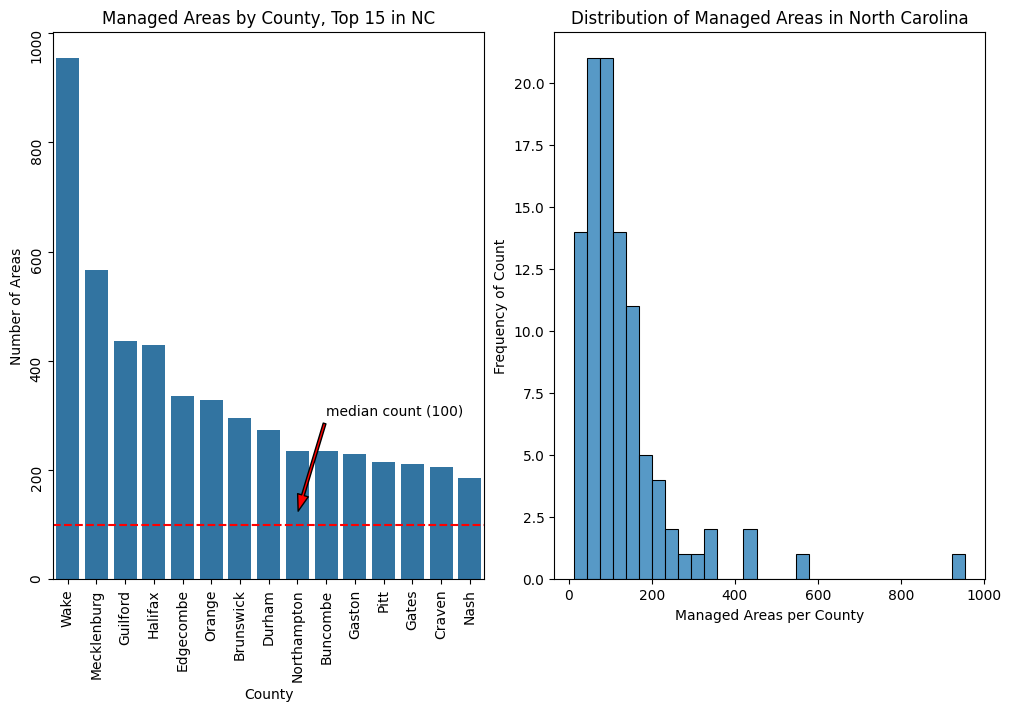

In [55]:
fig, ax = plt.subplots(ncols = 2, figsize = PLOT_1, constrained_layout = True)

(parks.groupby(["County"])
    .size()
    .sort_values(ascending = False)
    .head(15)
    .pipe((sns.barplot, 'data'), ax = ax[0])
)

ax[0].set_title("Managed Areas by County, Top 15 in NC")
ax[0].set(xlabel = "County", ylabel = "Number of Areas")
ax[0].axhline(y = parks.groupby(["County"]).size().median(), linestyle = '--', color = 'r')
ax[0].annotate("median count (100)", xy = (8,120), xytext = (9, 300), 
            arrowprops = ANNO_ARROW)
ax[0].tick_params(labelrotation = 90);

(parks.groupby(["County"])
    .size()
    .pipe((sns.histplot, 'data'), bins = 30, ax = ax[1])
)

ax[1].set_title("Distribution of Managed Areas in North Carolina")
ax[1].set(xlabel = "Managed Areas per County", ylabel = "Frequency of Count");

These two plots show just how much land with conservation as a primary function is centralized to a few counties. Wake and Mecklenburg are noteable outliers.

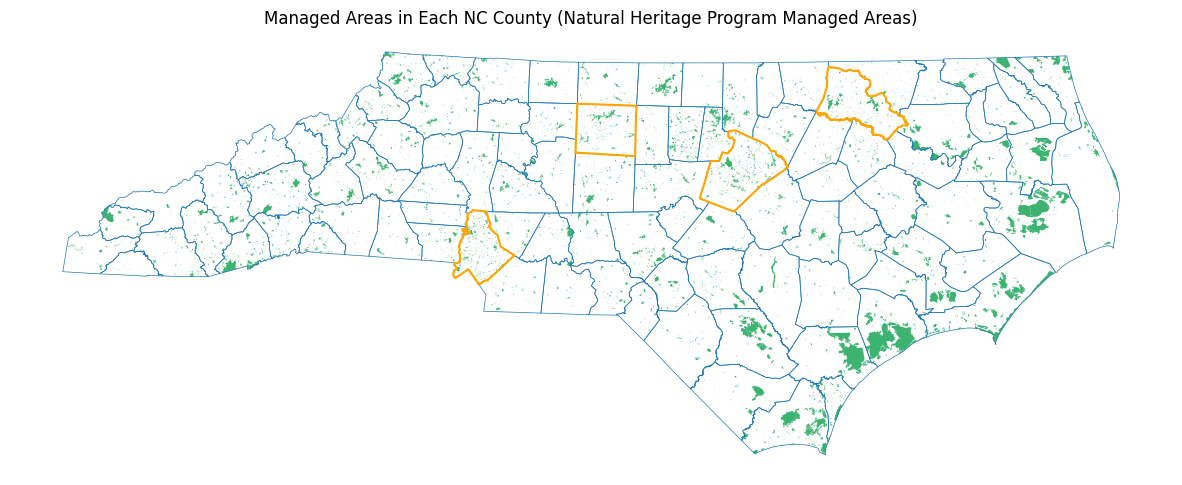

In [53]:
fig, ax = plt.subplots(figsize = NC_MAP_SIZE)
nc.boundary.plot(ax = ax, linewidth = 0.5)
for _,county in enumerate(["Wake", "Mecklenburg", "Guilford", "Halifax"]):
    nc[nc.County == county].boundary.plot(color = 'orange', ax = ax)
parks.to_crs(nc.crs).plot(ax = ax, color = PARK_COLOR)
plt.axis('off')

ax.set_title("Managed Areas in Each NC County (Natural Heritage Program Managed Areas)");

This map gives a view of the distributions of managed areas throughout the state. Wake, Guilford, Mecklenburg, and Halifax have been highlighed in orange. These counties had the most number of areas.

# Distribution of Training Data

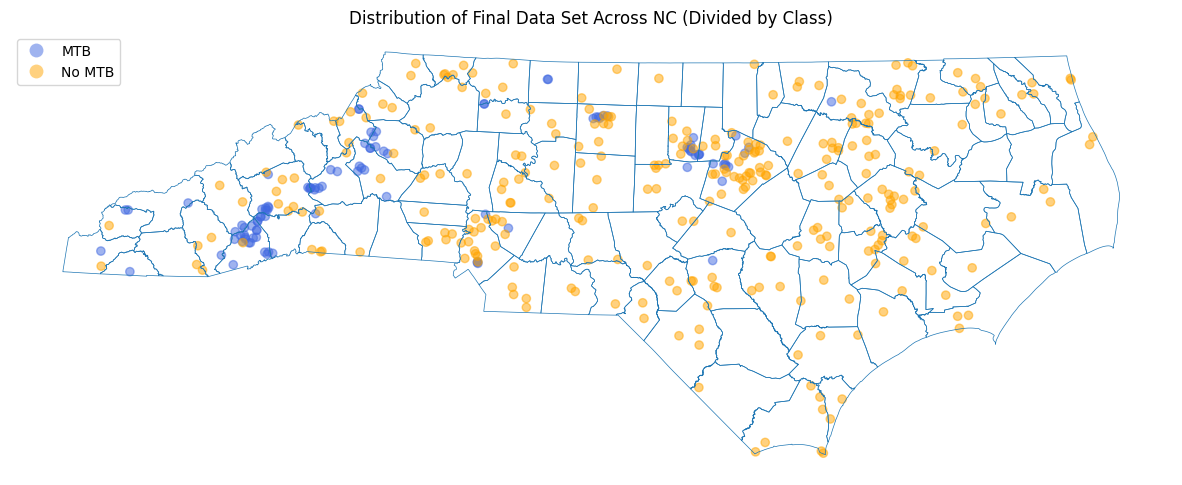

In [54]:
color_dict = { "MTB" : 'royalblue', "No MTB" : 'orange' }

fig, ax = plt.subplots(figsize = NC_MAP_SIZE)
nc.boundary.plot(ax = ax, linewidth = 0.5)
(tp_merge.assign(geometry = tp_merge.centroid)
    .plot(column = "land_use",
          cmap=colors.ListedColormap(list(color_dict.values())),
          alpha = 0.5,
          legend = True,
          ax = ax))
plt.axis('off')

ax.set_title("Distribution of Final Data Set Across NC (Divided by Class)");

Most of the mountain biking trails are centralized to a few areas, while the rest of the Non mountain biking areas are spread throughout the state.

Text(0.5, 0, 'Std. Deviation (feet)')

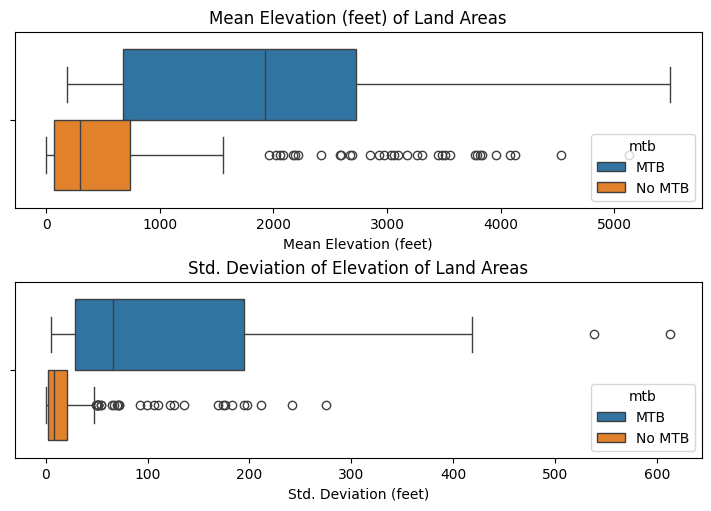

In [3]:
fig, ax = plt.subplots(nrows = 2, layout="constrained", figsize = (PX, PY))

sns.boxplot(x = "mean", hue = "mtb", data = trails_std, ax = ax[0])
ax[0].set_title("Mean Elevation (feet) of Land Areas")
ax[0].set_xlabel("Mean Elevation (feet)")
sns.boxplot(x = "sd", hue = "mtb", data = trails_std, ax = ax[1])
ax[1].set_title("Std. Deviation of Elevation of Land Areas")
ax[1].set_xlabel("Std. Deviation (feet)");

There definitely appears to be some seperation between areas that allow mountain biking and those that do not. Some of the difference is due to the fact that many of the mountain biking areas are in the mountains.

Text(0.5, 1.0, 'Frequency of Log2(Semivariance) Values at Lags 0, 7, and 14')

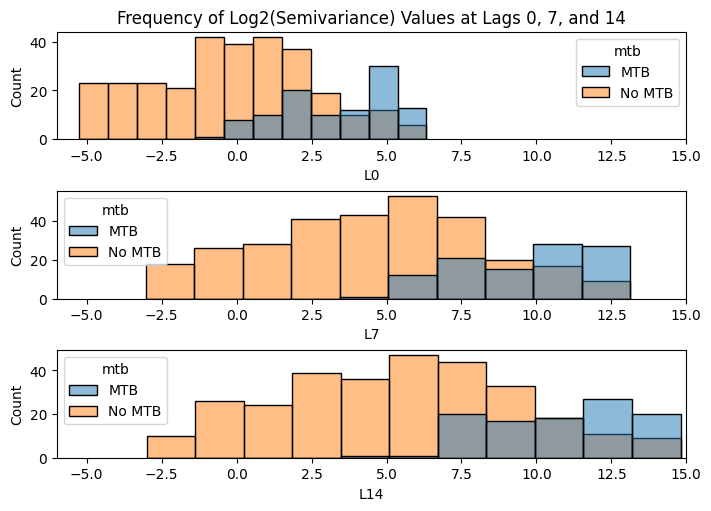

In [12]:
fig, ax = plt.subplots(nrows = 3, layout="constrained", figsize = (PX, PY))

# Lag Columns to 
lags = ["L0", "L7", "L14"]

for i,lag in enumerate(lags):
    sns.histplot(x = np.log2(trails_reg[lag]), hue = trails_reg.mtb, ax = ax[i])
    ax[i].set_xlim(xmin = -6, xmax = 15)

ax[0].set_title("Frequency of Log2(Semivariance) Values at Lags 0, 7, and 14");

I applied a log transformation for intuitive visualization of the relationship between the areas that allowed mountain biking and areas that did not. The above plot shows that all three distances there is separation between the classes. The higher values at all three intervals suggest that areas allowing mountain biking have rougher terrain.

Text(0.5, 1.0, 'Frequency of Semivariance Values Values at Lags 0, 7, and 14')

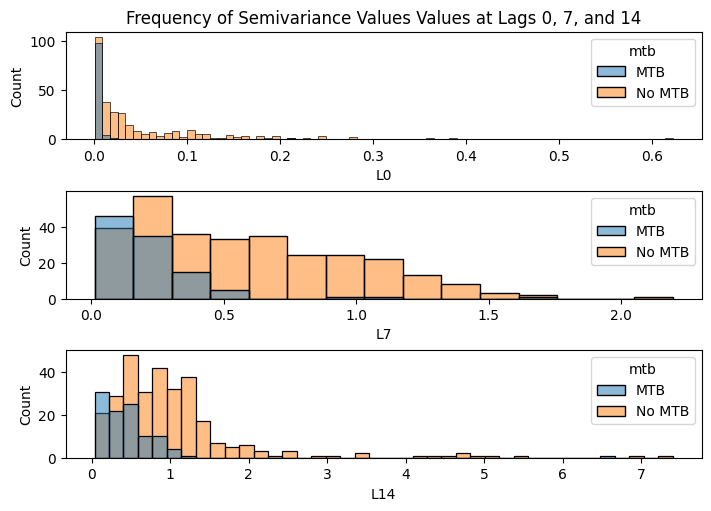

In [7]:
fig, ax = plt.subplots(nrows = 3, layout="constrained", figsize = (PX, PY))

# Lag Columns to 
lags = ["L0", "L7", "L14"]

for i,lag in enumerate(lags):
    sns.histplot(x = trails_std[lag], hue = trails_std.mtb, ax = ax[i])

ax[0].set_title("Frequency of Semivariance Values Values at Lags 0, 7, and 14");

I also created a set of lagged semivariance values where prior to computing I standardized the elevation values for each area independently. The goal of this was to avoid capturing overall elevation as an implicit predictor of suitability for trail building. This had the effect of almost reversing the relationship where the mountain biking trails appear to have smoother terrain.

# Missed Prediction Results

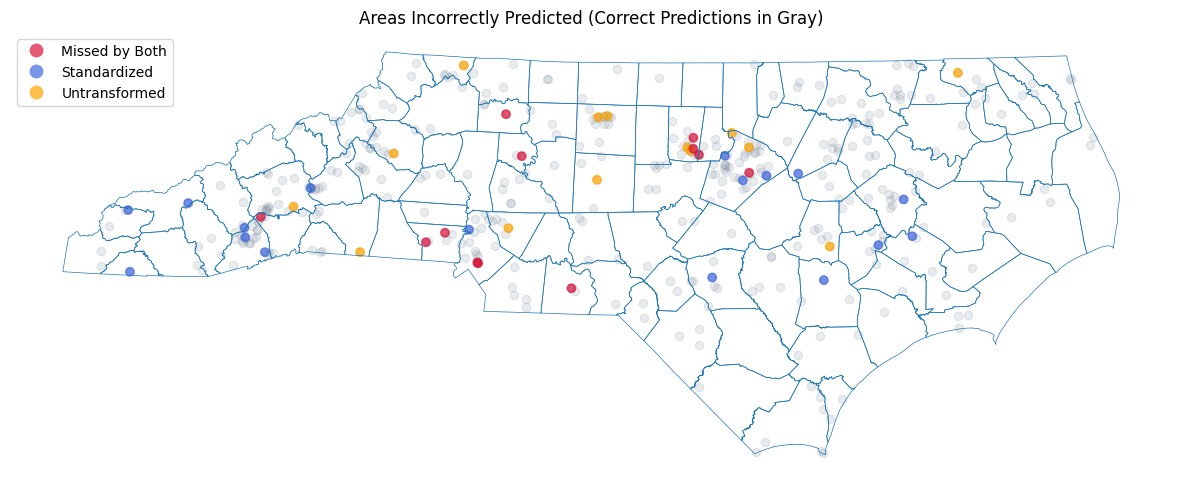

In [21]:
# Create labels for which data points were missed by each model
tp_merge["Missed"] = "Predicted by Both"
tp_merge.loc[pred[pred.mtb != pred.rf_reg].index, "Missed"] = "Untransformed"
tp_merge.loc[pred[pred.mtb != pred.rf_std].index, "Missed"] = "Standardized"
tp_merge.loc[pred[pred.missed == True].index, "Missed"] = "Missed by Both"

# Create color mapping
color_dict = { "Missed by Both" : 'crimson', "RandomForest" : 'royalblue', "XGBoost" : 'orange' }

fig, ax = plt.subplots(figsize = NC_MAP_SIZE)
nc.boundary.plot(ax = ax, linewidth = 0.5)
# Plot areas correctly predicted as light gray
(tp_merge.assign(geometry = tp_merge.centroid)
    .plot(color = 'slategray',
          alpha = 0.15,
          ax = ax))
(tp_merge.assign(geometry = tp_merge.centroid)
    .query('Missed != "Predicted by Both"')
    .plot(column = "Missed",
          cmap=colors.ListedColormap(list(color_dict.values())),
          alpha = 0.7,
          legend = True,
          ax = ax))
plt.axis('off')

ax.set_title("Areas Incorrectly Predicted (Correct Predictions in Gray)");

Areas missed by the model trained on the standardized data appear more distributed across the whole state. The model trained on the untransformed data appears to have more missed values in the Piedmont region. The exact nature of this relationship represents exciting directions for future research.